# Project: Fraud Detection 

## 1. Overview

### PaySim simulates mobile money transactions based on a sample of real transacions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world. The objective of the project is to predict if a transaction is fraudulent or not.

## 2. Preprocess the data

### Libraries

In [2]:
# libraries: mathematical computing
import numpy as np
import pandas as pd

# libraries: sklearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

# libraries: pyspark SparkContext
from pyspark import SparkContext, SparkConf

# libraries: pyspark sql
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from  pyspark.sql.functions import monotonically_increasing_id, desc, row_number
from pyspark.sql import SQLContext

# libraries: pyspark machine learning
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.mllib.stat import Statistics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel, TrainValidationSplit
from pyspark.ml.feature import HashingTF, Tokenizer, RFormula
from pyspark.ml.regression import RandomForestRegressor


# libraries: visualization
import seaborn as sb
import matplotlib.pyplot as mpt
import functools
from collections import Counter

In [3]:
# Creating a Spark-Context

sc = SparkContext.getOrCreate()

24/05/24 21:20:48 WARN Utils: Your hostname, Alexangels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.4 instead (on interface en0)
24/05/24 21:20:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 21:20:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Spark Builder

spark = SparkSession.builder.appName("fraudDetection").getOrCreate()

In [5]:
spark

In [6]:
# global variables

global df_bank, results 

#### We´ll use PySpark to preprocess the data.

In [7]:
# creation of the SparkSession

##spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
##spark

In [8]:
# spark dataframe 

df = spark.read.csv('fraudDetection.csv', header=True)

In [9]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")

24/05/24 21:20:58 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


#### Now, we´ll convert this "df" dataframe into a parquet file using the following method of pyspark. The file will be named "fraudDetection.parquet"

In [10]:
df.write.parquet("fraudDetection.parquet")

24/05/24 21:21:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
24/05/24 21:21:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
24/05/24 21:21:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
24/05/24 21:21:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
24/05/24 21:21:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
24/05/24 21:21:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
24/05/24 21:21:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

#### Now, we´ll read the file as a parquet file. The calculation will be faster.

In [11]:
df_bank_par = spark.read.parquet("fraudDetection.parquet")

#### Let´s take a look to the data with the first 10 rows.

In [12]:
df_bank_par.show(10)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|
|  35|CASH_IN|204719.93| C842268344|    908971.93|    1113691.86| C702268498|     531408.31|     326688.37|      0|             0|
|  35|CASH_IN|281004.16| C188755315|   1113691.86|    1394696.02|C1358158097|     6

In [13]:
df_bank_par.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



#### There are 11 columns, none of them is numerical (they are categorical). Let´s count the number of registers.

In [14]:
print(f"The total number of registers is:",df_bank_par.count())

The total number of registers is: 6362620


#### We have more than six miliions of transactions in the dataset.

### 2.1 Feature Engineering

#### Firstly, we´ll create a function to create a new variable.

In [15]:
### 2.1.1.- creation of a new variable: type2

df_type2 = df_bank_par.withColumn("type2",f.concat(f.substring("nameOrig",1,1),f.substring("nameDest",1,1)))

In [16]:
df_type2.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|   CC|
|  35|CASH_IN|204719.93| C842268344|    908971.93|    1113691.86| C702268498|     531408.31|     326688.37|      0|             0|   CC|
|  35|CASH_IN|281004.16| C188755315|   11

#### We´ve created a new column named "type2" which is composed by the first character of the column "nameOrig" and the first character of the column "nameDest"

In [17]:
### 2.1.2.1.- One Hot Encoding: column "type"

df_type2.show(3)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|   CC|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
only showing top 3 rows



#### We´ll use some libraries of Spark for Machine Learning (SparkML).

In [18]:
### StringIndexer Initialization
### column: type

indexer_type = StringIndexer(inputCol="type",outputCol="types_indexed")
indexerModel_type = indexer_type.fit(df_type2)


In [19]:
### Transform the DataFrame using the fitted StringIndexer model

indexed_df_type2 = indexerModel_type.transform(df_type2)
indexed_df_type2.show(10)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|          2.0|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|   CC|          2.0|
|  35|CASH_IN|204719.93| C842268344|    908971.93|    1113691.86| C702268498|     531408.31|  

#### Here, we´ve set each of the elements of the "type" column into indexes.

In [20]:
### apply One-Hot-Encoding to the indexed column, that is, 
### "types_indexed"

encoder_type = OneHotEncoder(dropLast=False, inputCol="types_indexed", outputCol="types_onehot")
encoder_type_df = encoder_type.fit(indexed_df_type2).transform(indexed_df_type2)
encoder_type_df.show(truncate=False)


+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed|types_onehot |
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+
|35  |CASH_IN |312070.89|C154541954 |334944.3     |647015.19     |C1995182035|1030393.8     |718322.91     |0      |0             |CC   |2.0          |(5,[2],[1.0])|
|35  |CASH_IN |244107.21|C1988196004|647015.19    |891122.4      |C877334652 |792091.74     |547984.53     |0      |0             |CC   |2.0          |(5,[2],[1.0])|
|35  |CASH_IN |17849.53 |C1469762907|891122.4     |908971.93     |C733481207 |107400.33     |89550.8       |0      |0             |CC   |2.0          |(5,[2],[1.0])|
|35 

In [21]:
encoder_type_df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)
 |-- type2: string (nullable = true)
 |-- types_indexed: double (nullable = false)
 |-- types_onehot: vector (nullable = true)



In [22]:
encoder_type_df_split = encoder_type_df.select('*',vector_to_array('types_onehot').alias('types_onehot_split'))
encoder_type_df_split.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733

In [23]:
### now, we´ll split the "types_onehot_split" into five columns, one per category

num_categories = len(encoder_type_df_split.first()['types_onehot_split'])
cols_expanded = [(f.col('types_onehot_split')[i].alias(f"{indexerModel_type.labels[i]}")) for i in range(num_categories)]
type_df = encoder_type_df_split.select('*',*cols_expanded)


In [24]:
type_df.show(100)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|  35| CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|     0.0|    0.0|    1.0|     0.0|  0.0|
|  35| CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74

#### We´ve applied One-Hot-Encoding to the column "type" resulting in five new columns:
+ CASH_OUT
+ CASH_IN
+ PAYMENT
+ TRANSFER 
+ DEBIT

#### Now, we´ll apply this procedure to the column "type2".

In [25]:
### 2.1.2.2.- One Hot Encoding: column "type2"

type_df.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|     0.0|    0.0|    1.0|     0.0|  0.0|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|    

In [26]:
### StringIndexer Initialization
### column: type2

indexer_type = StringIndexer(inputCol="type2",outputCol="types_indexed2")
indexerModel_type = indexer_type.fit(type_df)

In [27]:
### Transform the DataFrame using the fitted StringIndexer model

indexed_df_type = indexerModel_type.transform(type_df)
indexed_df_type.show(10)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|     0.0|    0.0|    1.0|     0.0|  0.0|           0.0|
|  35|CASH_IN|244107.21|C1988196004|

In [28]:
### apply One-Hot-Encoding to the indexed column, that is, 
### "types_indexed2"

encoder_type2 = OneHotEncoder(dropLast=False, inputCol="types_indexed2", outputCol="types_onehot2")
encoder_type2_df = encoder_type2.fit(indexed_df_type).transform(indexed_df_type)
encoder_type2_df.show(truncate=False)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+-------------------------+--------+-------+-------+--------+-----+--------------+-------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed|types_onehot |types_onehot_split       |CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|types_onehot2|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+-------------------------+--------+-------+-------+--------+-----+--------------+-------------+
|35  |CASH_IN |312070.89|C154541954 |334944.3     |647015.19     |C1995182035|1030393.8     |718322.91     |0      |0             |CC   |2.0          |(5,[2],[1.0])|[0.0, 0.0, 1.0, 0.0, 0.0]|0.0     |0.0    |1.0    |0

In [29]:
encoder_type2_df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)
 |-- type2: string (nullable = true)
 |-- types_indexed: double (nullable = false)
 |-- types_onehot: vector (nullable = true)
 |-- types_onehot_split: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- types_indexed2: double (nullable = false)
 |-- types_onehot2: vector (nullable = true)



In [30]:
encoder_type2_df_split = encoder_type2_df.select('*',vector_to_array('types_onehot2').alias('types_onehot_split2'))
encoder_type2_df_split.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|types_onehot2|types_onehot_split2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 

In [31]:
### now, we´ll split the "types_onehot_split2" into two columns, one per category

num_categories = len(encoder_type2_df_split.first()['types_onehot_split2'])
cols_expanded = [(f.col('types_onehot_split2')[i].alias(f"{indexerModel_type.labels[i]}")) for i in range(num_categories)]
encoder_type2_df_split = encoder_type2_df_split.select('*',*cols_expanded)

In [32]:
encoder_type2_df_split.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+---+---+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|types_onehot2|types_onehot_split2| CC| CM|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+---+---+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(

#### We´ve split the "type2" column into two columns based on One-Hot-Encoding. Now, we´ll eliminate some unnecessaruy columns. Let´s check out all the columns.

In [33]:
encoder_type2_df_split.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)
 |-- type2: string (nullable = true)
 |-- types_indexed: double (nullable = false)
 |-- types_onehot: vector (nullable = true)
 |-- types_onehot_split: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- types_indexed2: double (nullable = false)
 |-- types_onehot2: vector (nullable = true)
 |-- types_onehot_split2

In [34]:
### StringIndexer Initialization
### column: step

#indexer_type = StringIndexer(inputCol="step",outputCol="types_indexed3")
#indexerModel_type = indexer_type.fit(type_df)


### Transform the DataFrame using the fitted StringIndexer model

#indexed_df_type = indexerModel_type.transform(type_df)
#indexed_df_type.show(10)


### apply One-Hot-Encoding to the indexed column, that is, 
### "types_indexed2"

#encoder_type2 = OneHotEncoder(dropLast=False, inputCol="types_indexed3", outputCol="types_onehot3")
#encoder_type2_df = encoder_type2.fit(indexed_df_type).transform(indexed_df_type)
#encoder_type2_df.show(truncate=False)

#encoder_type2_df_split = encoder_type2_df.select('*',vector_to_array('types_onehot3').alias('types_onehot_split3'))
#encoder_type2_df_split.show(5)

### now, we´ll split the "types_onehot_split2" into two columns, one per category

#num_categories = len(encoder_type2_df_split.first()['types_onehot_split3'])
#cols_expanded = [(f.col('types_onehot_split3')[i].alias(f"{indexerModel_type.labels[i]}")) for i in range(num_categories)]
#encoder_type2_df_split = encoder_type2_df_split.select('*',*cols_expanded)

#### Now, we´ll eliminate the unnecessary columns:
+ nameOrig
+ nameDest
+ isFlaggedFraud
+ newbalanceDest
+ oldbalanceDest
+ oldbalanceOrg
+ newbalanceOrig 
+ types_indexed
+ types_onehot
+ types_onehot_split
+ types_indexed2
+ types_onehot2
+ types_onehot_split2
+ type
+ type2

In [35]:
df_bank_par = encoder_type2_df_split.drop("nameOrig","nameDest","isFlaggedFraud","newbalanceDest","oldbalanceDest",
                       "oldbalanceOrg","newbalanceOrig","type","types_indexed","types_onehot",
                       "types_onehot_split","type2","types_indexed2","types_onehot2","types_onehot_split2","types_indexed3","types_onehot3","types_onehot_split3" )
df_bank_par.show(5)

+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|step|   amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|  35|312070.89|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|244107.21|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35| 17849.53|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|204719.93|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|281004.16|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
+----+---------+-------+--------+-------+-------+--------+-----+---+---+
only showing top 5 rows



In [36]:
df_bank_par.columns

['step',
 'amount',
 'isFraud',
 'CASH_OUT',
 'PAYMENT',
 'CASH_IN',
 'TRANSFER',
 'DEBIT',
 'CC',
 'CM']

In [37]:
df_bank_par.count()

6362620

In [38]:
type(df_bank_par)

pyspark.sql.dataframe.DataFrame

#### We can see that there are the same quantity of registers.

### 2.2 Data Cleaning

In [39]:
### 2.2.1.- Eliminate duplicated

num_all_rows = df_bank_par.count()
num_all_rows

6362620

In [40]:
num_duplicated_rows = df_bank_par.distinct().count() 

24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:33 WARN RowBasedKeyValueBatch: Calling spill() on

In [41]:
print(f"The total number of duplicated rows is:",num_all_rows - num_duplicated_rows)

The total number of duplicated rows is: 7597


#### We can see that there are 7597 duplicated rows. Let´s remove the null values and duplicated values from the df_bank_par dataframe.

In [42]:
df_bank_par = df_bank_par.dropna()

df_bank_par = df_bank_par.dropDuplicates()

In [43]:
df_bank_par.count()

24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:21:50 WARN RowBasedKeyValueBatch: Calling spill() on

6355023

#### We can see the duplicated registers have been removed because there are fewer registers than before. Let´s take a look at the "clean" dataset.

In [44]:
df_bank_par.show(10)

24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/24 21:22:02 WARN RowBasedKeyValueBatch: Calling spill() on

+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|step|   amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|  35| 23148.99|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35| 21158.22|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35|  7326.08|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35|248000.14|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|   227.92|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35| 74827.29|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35| 36205.75|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|  35| 25359.28|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|  35|  3579.31|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35| 11931.85|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
+----+---------+-------+--------+-------+-------+--

## 3. Exploratory Data Analysis (EDA)

### 3.1 Visualization

#### The visualization will be done using a functions which leverages the method histogram() of pyspark. 

In [45]:
# definition of the "histogram" function

def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    mpt.bar(loc, vals[1], width=width)
    mpt.xlabel(col)
    mpt.ylabel(yname)
    mpt.show()

#### There are some features that need to be converted to integers such as "step","amount" and "isFraud".

In [46]:
# convert string columns into integer columns

df_bank_par = df_bank_par.withColumn("step",df_bank_par["step"].cast(IntegerType()))

In [47]:
df_bank_par = df_bank_par.withColumn("amount",df_bank_par["amount"].cast(IntegerType()))

In [48]:
df_bank_par = df_bank_par.withColumn("isFraud",df_bank_par["isFraud"].cast(IntegerType()))

In [49]:
df_bank_par.printSchema()

root
 |-- step: integer (nullable = true)
 |-- amount: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- CC: double (nullable = true)
 |-- CM: double (nullable = true)



In [50]:
type(df_bank_par)

pyspark.sql.dataframe.DataFrame

#### We´ve seen that all the features are "integer" types now. Therefore, we´re able to perform various visualizations with the histogram method. That´s what we´ll do next.

In [51]:
# histogram: "step"

##histogram(df_bank_par, 'step', bins=15, yname='frequency')

In [52]:
# histogram: "amount"

##histogram(df_bank_par, 'amount', bins=15, yname='frequency')

In [53]:
# histogram: "Debit"

##histogram(df_bank_par, 'Debit', bins=15, yname='frequency')


In [54]:
# histogram: "Payment"

##histogram(df_bank_par, 'Payment', bins=15, yname='frequency')


In [55]:
# histogram: "CASH_OUT"

##histogram(df_bank_par, 'CASH_OUT', bins=15, yname='frequency')


In [56]:
# histogram: "CASH_IN"

##histogram(df_bank_par, 'CASH_IN', bins=15, yname='frequency')


In [57]:
# histogram: "TRANSFER"

##histogram(df_bank_par, 'TRANSFER', bins=15, yname='frequency')


In [58]:
# histogram: "CC"

##histogram(df_bank_par, 'CC', bins=15, yname='frequency')


In [59]:
# histogram: "CM"

##histogram(df_bank_par, 'CM', bins=15, yname='frequency')

In [60]:
# histogram: "isFraud"

##histogram(df_bank_par, 'isFraud', bins=15, yname='frequency')

#### Remember that our label is "isFraud", therefore, we can see that this class is unbalanced as we can see from the previous graphic. We need to perform an **Oversampling** through ***Data Balancing*** using *pyspark*.

### 3.2 Data Balancing

In [61]:
############################################################## Oversampling with PySpark #########################################################

# Create undersampling function
#def oversample_minority(df, ratio=1):
#    '''
#    ratio is the ratio of majority to minority
#    Eg. ratio 1 is equivalent to majority:minority = 1:1
#    ratio 5 is equivalent to majority:minority = 5:1
#    '''
#    minority_count = df.filter(f.col('isFraud')==1).count()
#    majority_count = df.filter(f.col('isFraud')==0).count()
#    
#    balance_ratio = majority_count / minority_count
#    
#    print(f"Initial Majority:Minority ratio is {balance_ratio:.2f}:1")
#    if ratio >= balance_ratio:
#        print("No oversampling of minority was done as the input ratio was more than or equal to the initial ratio.")
#    else:
#        print(f"Oversampling of minority done such that Majority:Minority ratio is {ratio}:1")
#    
#    oversampled_minority = df.filter(f.col('isFraud')==1).sample(withReplacement=True, fraction=(balance_ratio/ratio),seed=88)
#    oversampled_df = df.filter(f.col('isFraud')==0).union(oversampled_minority)
#    
#    return oversampled_df

#oversampled_df = oversample_minority(df_bank_par,ratio=1)

#minority_count = oversampled_df.filter(f.col('isFraud')==1).count()
#majority_count = oversampled_df.filter(f.col('isFraud')==0).count()
#minority_count, majority_count
#oversampled_df = oversampled_df.dropna()
#oversampled_df = oversampled_df.dropDuplicates()
#df_bank_par = oversampled_df


#### If we want to transform this pyspark "dataframe" df_bank_par into a pandas dataframe we can use the method to_pandas_on_spark.

In [62]:
df_bank_pandas = pd.read_csv('fraudDetection.csv')

In [63]:
type(df_bank_pandas)

pandas.core.frame.DataFrame

In [64]:
#@title
def procesar_datos():
  global df_banco, resultados
  df_banco=df_bank_pandas.copy()
  # Crea la nueva variable type2 con la combinación de la primera letra de las columnas nameOrig y nameDest
  df_banco['type2'] = df_banco['nameOrig'].str[0] + df_banco['nameDest'].str[0]

In [65]:
procesar_datos()
df_banco.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,CM
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,CM
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,CM
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,CM
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,CM
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,CM
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,CM
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,CC


In [66]:
# Realiza one-hot encoding de las columnas type y type2
df_encoded = pd.get_dummies(df_banco, columns=['type', 'type2'], dtype=int)
df_encoded.sample(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
4484297,324,13446.95,C509087326,0.00,0.00,C1402213524,1156927.73,1170374.68,0,0,0,1,0,0,0,1,0
4897438,349,148142.70,C452949359,9324518.87,9472661.57,C712878492,1398652.10,1250509.40,0,0,1,0,0,0,0,1,0
1056198,96,769.12,C105247912,19913.00,19143.88,M1972533505,0.00,0.00,0,0,0,0,0,1,0,0,1
3867227,283,142920.56,C1602679819,15470.00,0.00,C1369248966,49794.68,192715.24,0,0,0,1,0,0,0,1,0
6160257,548,208882.31,C1341557859,0.00,0.00,C1369390187,310461.68,519344.00,0,0,0,1,0,0,0,1,0
3818101,281,57515.66,C1960017515,166.00,0.00,C1700524560,4849916.91,4907432.58,0,0,0,0,0,0,1,1,0
3968226,297,18482.63,C1342698466,0.00,0.00,M2132483009,0.00,0.00,0,0,0,0,0,1,0,0,1
1597263,156,2030.15,C1602652519,788237.58,786207.43,M51920892,0.00,0.00,0,0,0,0,0,1,0,0,1
2536251,205,114485.38,C44332445,21882.00,0.00,C806678283,0.00,114485.38,0,0,0,1,0,0,0,1,0
3678720,276,3199.41,C612315473,19952.00,16752.59,M1372916846,0.00,0.00,0,0,0,0,0,1,0,0,1


In [67]:
# Lista de columnas a eliminar
columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
# Elimina las columnas del DataFrame
df_encoded.drop(columns=columns_to_drop, inplace=True)
# Resetea el índice
df_encoded.reset_index(drop=True, inplace=True)
df_encoded


,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,1,0,1,0,0,0,1,0
6362616,743,6311409.28,1,0,0,0,0,1,1,0
6362617,743,6311409.28,1,0,1,0,0,0,1,0
6362618,743,850002.52,1,0,0,0,0,1,1,0


In [68]:
# Elimina registros duplicados y guarda el resultado en df_banco
df_banco = df_encoded.drop_duplicates()

In [69]:
# Elimina registros con valores nulos y restablece el índice
df_banco.dropna(inplace=True)
df_banco.reset_index(drop=True, inplace=True)

/var/folders/0n/zwbn7zz13l7c9kw1ccdb5qb80000gn/T/ipykernel_80684/2381833487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_banco.dropna(inplace=True)


In [70]:
df_banco

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6355018,743,339682.13,1,0,1,0,0,0,1,0
6355019,743,6311409.28,1,0,0,0,0,1,1,0
6355020,743,6311409.28,1,0,1,0,0,0,1,0
6355021,743,850002.52,1,0,0,0,0,1,1,0


In [71]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6355023 entries, 0 to 6355022
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   step           int64  
 1   amount         float64
 2   isFraud        int64  
 3   type_CASH_IN   int64  
 4   type_CASH_OUT  int64  
 5   type_DEBIT     int64  
 6   type_PAYMENT   int64  
 7   type_TRANSFER  int64  
 8   type2_CC       int64  
 9   type2_CM       int64  
dtypes: float64(1), int64(9)
memory usage: 484.8 MB


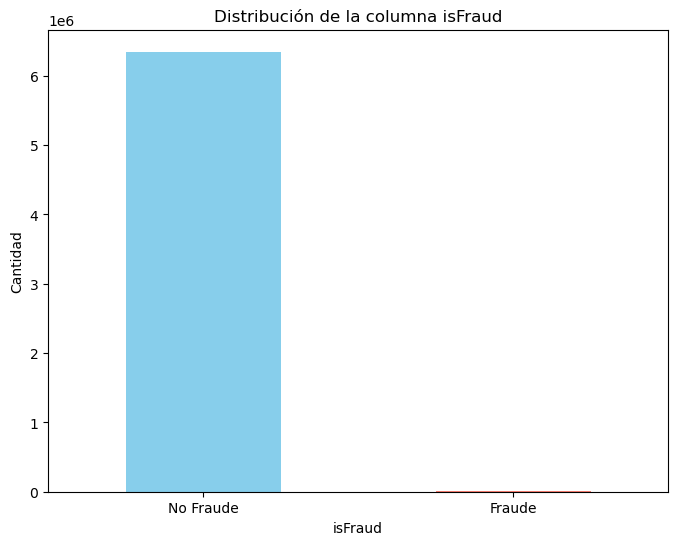

In [72]:
# Contar los valores de la columna isFraud
conteo_isfraud = df_banco['isFraud'].value_counts()

# Crear el gráfico de barras verticales
mpt.figure(figsize=(8, 6))
conteo_isfraud.plot(kind='bar', color=['skyblue', 'salmon'])
mpt.title('Distribución de la columna isFraud')
mpt.xlabel('isFraud')
mpt.ylabel('Cantidad')
mpt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
mpt.show()

In [73]:
#@title

def balanceo_clases():
    global df_banco, resultados

    # Instancia SMOTE
    smote = SMOTE(random_state=42)

    # Balanceo de clases
    X_res, y_res = smote.fit_resample(df_banco.drop(columns=['isFraud']), df_banco['isFraud'])

    # Reconstrucción del DataFrame balanceado
    df_banco = pd.DataFrame(X_res, columns=df_banco.drop(columns=['isFraud']).columns)
    df_banco['isFraud'] = y_res

    # Elimina registros duplicados
    df_banco.drop_duplicates(inplace=True)
    df_banco.reset_index(drop=True, inplace=True)

# Llama a la función balanceo_clases
balanceo_clases()

# Imprime el resultado final
df_banco

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
0,1,9839.640000,0,0,0,1,0,0,1,0
1,1,1864.280000,0,0,0,1,0,0,1,0
2,1,181.000000,0,0,0,0,1,1,0,1
3,1,181.000000,0,1,0,0,0,1,0,1
4,1,11668.140000,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
11316844,72,59132.865542,0,0,0,0,0,1,0,1
11316845,262,213293.869235,0,1,0,0,0,1,0,1
11316846,592,468613.275827,0,1,0,0,0,1,0,1
11316847,195,295040.631306,0,0,0,0,1,1,0,1


In [74]:
type(df_banco)

pandas.core.frame.DataFrame

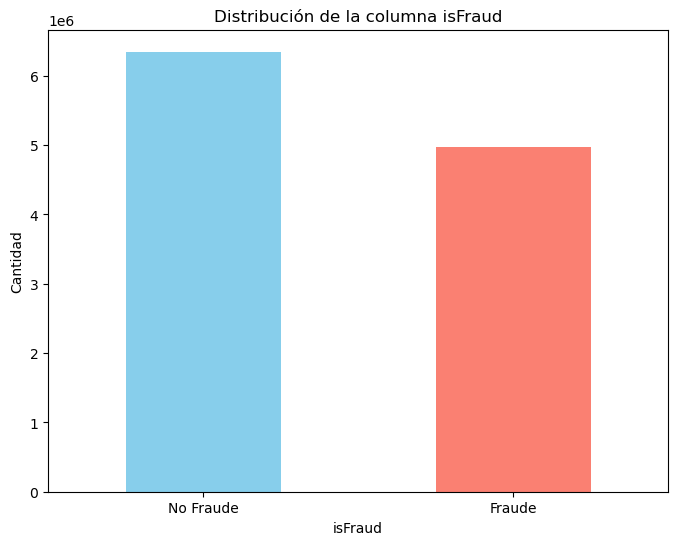

In [75]:
# Contar los valores de la columna isFraud
conteo_isfraud = df_banco['isFraud'].value_counts()

# Crear el gráfico de barras verticales
mpt.figure(figsize=(8, 6))
conteo_isfraud.plot(kind='bar', color=['skyblue', 'salmon'])
mpt.title('Distribución de la columna isFraud')
mpt.xlabel('isFraud')
mpt.ylabel('Cantidad')
mpt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
mpt.show()

In [76]:
type(df_banco)

pandas.core.frame.DataFrame

#### Now, we´ll convert this pandas dataframe into a PySpark dataframe to leverage, but first to a parquet file.

In [77]:
df_banco.to_parquet('df.parquet')

In [78]:
df_bank_par = spark.read.parquet('df.parquet')

In [79]:
type(df_bank_par)

pyspark.sql.dataframe.DataFrame

In [80]:
df_bank_par.show(10)

+----+--------+------------+-------------+----------+------------+-------------+--------+--------+-------+
|step|  amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|
+----+--------+------------+-------------+----------+------------+-------------+--------+--------+-------+
|   1| 9839.64|           0|            0|         0|           1|            0|       0|       1|      0|
|   1| 1864.28|           0|            0|         0|           1|            0|       0|       1|      0|
|   1|   181.0|           0|            0|         0|           0|            1|       1|       0|      1|
|   1|   181.0|           0|            1|         0|           0|            0|       1|       0|      1|
|   1|11668.14|           0|            0|         0|           1|            0|       0|       1|      0|
|   1| 7817.71|           0|            0|         0|           1|            0|       0|       1|      0|
|   1| 7107.77|           0|         

In [81]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: long (nullable = true)



In [82]:
df_bank_par.count()

11316849

In [83]:
# convert string columns into integer columns

df_bank_par = df_bank_par.withColumn("isFraud",df_bank_par["isFraud"].cast(IntegerType()))

In [84]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: integer (nullable = true)



In [85]:
class_0 = df_bank_par.filter(f.col("isFraud")==0)
class_1 = df_bank_par.filter(f.col("isFraud")==1)

In [86]:
class_0.count()

6346920

In [87]:
class_1.count()

4969929

In [88]:
######################################## Convert parquet file into Pandas ##########################

##df_bank_par_pandas = df_bank_par.to_pandas_on_spark()
##df_bank_par_pandas.head(10)
##df_bank_par_pandas.describe()
##type(df_bank_par_pandas)

#### Let´s create a function to find a correlation between the target variable "isFraud" and the features. 

In [89]:
# definition of the function "correlation_df"

def correlation_df(df,target_var,feature_cols, method):
    # assemble features into a vector
    target_var = [target_var]
    feature_cols = feature_cols
    df_cor = df.select(target_var + feature_cols)
    assembler = VectorAssembler(inputCols=target_var + feature_cols, outputCol="features")
    df_cor = assembler.transform(df_cor)

    # calculate correlation matrix
    correlation_matrix = Correlation.corr(df_cor, "features", method =method).head()[0]

    # extract the correlation coefficient between target and each feature
    target_corr_list = [correlation_matrix[i,0] for i in range(len(feature_cols)+1)][1:]

    # create a Dataframe with target variable, feature names and correlation coefficients
    correlation_data = [(feature_cols[i],float(target_corr_list[i])) for i in range(len(feature_cols))]

    correlation_df = spark.createDataFrame(correlation_data, ["feature","correlation"] )

    correlation_df = correlation_df.withColumn("abs_correlation",f.abs("correlation"))

    # print the result
    return correlation_df

In [90]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: integer (nullable = true)



In [91]:
target = "isFraud"

indep_cols = [x for x in df_bank_par.columns if x not in [target] ]

corr_values_df = correlation_df(df=df_bank_par, target_var= target, feature_cols= indep_cols, method='pearson')

print(f"The corelation between {target} and the other features is: ")

corr_values_df.show()


24/05/24 21:22:31 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:31 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:31 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:31 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:31 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The corelation between isFraud and the other features is: 
+-------------+--------------------+-------------------+
|      feature|         correlation|    abs_correlation|
+-------------+--------------------+-------------------+
|         step| 0.34684009076918143|0.34684009076918143|
|       amount|  0.3604992933016074| 0.3604992933016074|
| type_CASH_IN| -0.3323385816575818| 0.3323385816575818|
|type_CASH_OUT|-0.10691980783674657|0.10691980783674657|
|   type_DEBIT|-0.05363819819216311|0.05363819819216311|
| type_PAYMENT| -0.4282609844322808| 0.4282609844322808|
|type_TRANSFER| 0.22944948951215355|0.22944948951215355|
|     type2_CC| 0.42826098443228067|0.42826098443228067|
|     type2_CM| -0.4282609844322808| 0.4282609844322808|
+-------------+--------------------+-------------------+



In [92]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: integer (nullable = true)



In [93]:
target = "amount"

indep_cols = [x for x in df_bank_par.columns if x not in [target] ]

corr_values_df = correlation_df(df=df_bank_par, target_var= target, feature_cols= indep_cols, method='pearson')

print(f"The corelation between {target} and the other features is: ")

corr_values_df.show()


24/05/24 21:22:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:22:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The corelation between amount and the other features is: 
+-------------+--------------------+--------------------+
|      feature|         correlation|     abs_correlation|
+-------------+--------------------+--------------------+
|         step| 0.12429095205369503| 0.12429095205369503|
| type_CASH_IN|-0.12114623126047482| 0.12114623126047482|
|type_CASH_OUT|  -0.041412031021294|   0.041412031021294|
|   type_DEBIT|-0.02682257141276...|0.026822571412764645|
| type_PAYMENT| -0.2114653262805776|  0.2114653262805776|
|type_TRANSFER| 0.15105593069727094| 0.15105593069727094|
|     type2_CC| 0.21146532628056097| 0.21146532628056097|
|     type2_CM| -0.2114653262805776|  0.2114653262805776|
|      isFraud|  0.3604992933016071|  0.3604992933016071|
+-------------+--------------------+--------------------+



In [94]:
target = "step"

indep_cols = [x for x in df_bank_par.columns if x not in [target] ]

corr_values_df = correlation_df(df=df_bank_par, target_var= target, feature_cols= indep_cols, method='pearson')

print(f"The corelation between {target} and the other features is: ")

corr_values_df.show()

24/05/24 21:23:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:23:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:23:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:23:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:23:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The corelation between step and the other features is: 
+-------------+--------------------+--------------------+
|      feature|         correlation|     abs_correlation|
+-------------+--------------------+--------------------+
|       amount| 0.12429095205369503| 0.12429095205369503|
| type_CASH_IN|-0.11255059686687098| 0.11255059686687098|
|type_CASH_OUT|-0.04565434924107...|0.045654349241078744|
|   type_DEBIT|-0.01678650820881...|0.016786508208811435|
| type_PAYMENT|-0.14515981565813296| 0.14515981565813296|
|type_TRANSFER| 0.08329816241940949| 0.08329816241940949|
|     type2_CC|  0.1451598156581346|  0.1451598156581346|
|     type2_CM|-0.14515981565813296| 0.14515981565813296|
|      isFraud| 0.34684009076918176| 0.34684009076918176|
+-------------+--------------------+--------------------+



## 4. Construction of models

## 4.1 train/test split

In [95]:
train,test = df_bank_par.randomSplit([0.7,0.3])

#### Let´s assemble these datasets "train" and "test" into a single feature vector using VectorAssembler class per each one.

In [96]:
# let´s assemble the train dataset as a single feature vector using VectorAssembler class

columns = ['step','amount','type_CASH_OUT','type_PAYMENT','type_CASH_IN','type_TRANSFER','type_DEBIT','type2_CC','type2_CM','isFraud']

assembler = VectorAssembler(inputCols=columns, outputCol='features')

train = assembler.transform(train).withColumnRenamed("features", "my_features")

train.show(10)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|   1|  6.42|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1|  6.93|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1|  8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 13.54|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 23.31|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],

In [97]:
# let´s assemble the test dataset as a single feature vector using VectorAssembler class

columns = ['step','amount','type_CASH_OUT','type_PAYMENT','type_CASH_IN','type_TRANSFER','type_DEBIT','type2_CC','type2_CM','isFraud']

assembler = VectorAssembler(inputCols=columns, outputCol='features')

test = assembler.transform(test).withColumnRenamed("features", "my_features")

test.show(10)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|   1| 15.06|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1|  42.0|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 53.35|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 96.32|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1|137.88|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],

## 4.2 Models

We´ll use several machine learning algorithms to evaluate all of them and to select the best one. We´ll start with Random Forest. However, it´s important to create some lists where to store the results of the models:

In [100]:
name_model = []

accuracy = []

precision = []

recall = []

auc_roc = []

### 4.2.1 Random Forest

#### Training

In [98]:
# train the model "random forest" (rf)

rf = RandomForestRegressor(labelCol='isFraud',featuresCol='features')
##model_RF = rf.fit(train)

In [102]:
rf = RandomForestRegressor().setLabelCol("isFraud").setFeaturesCol("features")

In [103]:
rf.explainParam

<bound method Params.explainParam of RandomForestRegressor_4dd5ccd5d457>

In [104]:
rForm = RFormula(formula = "lab")
assembler

VectorAssembler_a5df87f773eb

In [98]:
# Pipeline

stages = [assembler,rf]

pipeline = Pipeline().setStages(stages) # type: ignore

In [99]:
params = ParamGridBuilder()\
         .addGrid(rf.numTrees, [1,2,3,4,5])\
         .addGrid(rf.maxDepth, [1,2,3,4,5])\
         .build()

In [100]:
# evaluator

evaluator = BinaryClassificationEvaluator()\
            .setMetricName("areaUnderROC")\
            .setRawPredictionCol("prediction")\
            .setLabelCol("isFraud")

In [101]:
# TrainValidationSplit

tvs = TrainValidationSplit()\
      .setTrainRatio(0.75)\
      .setEstimatorParamMaps(params)\
      .setEstimator(pipeline)\
      .setEvaluator(evaluator)


In [102]:
tvsFitted = tvs.fit(train)


24/05/24 20:21:42 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 20:21:42 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 20:21:48 WARN MemoryStore: Not enough space to cache rdd_241_8 in memory! (computed 24.4 MiB so far)
24/05/24 20:21:48 WARN MemoryStore: Not enough space to cache rdd_241_9 in memory! (computed 24.4 MiB so far)
24/05/24 20:21:48 WARN MemoryStore: Not enough space to cache rdd_241_3 in memory! (computed 23.6 MiB so far)
24/05/24 20:21:48 WARN MemoryStore: Not enough space to cache rdd_241_2 in memory! (computed 23.6 MiB so far)
24/05/24 20:21:48 WARN MemoryStore: Not enough space to cache rdd_241_5 in memory! (computed 24.4 MiB so far)
24/05/24 20:21:48 WARN

ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
evaluator.evaluate(tvsFitted.transform(train))

NameError: name 'tvsFitted' is not defined

In [ ]:
lr = LogisticRegression()

In [ ]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [ ]:
rf.getMaxDepth()

15

In [ ]:
model_RF = rf.fit(train)

24/05/20 00:30:29 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/20 00:30:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/20 00:30:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/20 00:30:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/20 00:30:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [ ]:
rf.getNumTrees()

20

In [ ]:
type(rf)

pyspark.ml.regression.RandomForestRegressor

Now, we put our simple, two-stage workflow into an ML pipeline.

In [99]:
pipeline = Pipeline(stages=[assembler,rf])

In [ ]:
type(pipeline)

pyspark.ml.pipeline.Pipeline

#### Hyperparameter GRID

In [100]:
# ParamGridBuilder

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [int(x) for x in np.linspace(start=10, stop=12, num=3)])\
            .addGrid(rf.maxDepth,[int(x) for x in np.linspace(start=5, stop=7, num=3)])\
            .build()

In [101]:
# CrossValidator

crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, \
                          evaluator=RegressionEvaluator().setLabelCol("isFraud"),numFolds=3
                         )



In [102]:
# Cross Validation Model: train

cvModel = crossval.fit(train)

24/05/24 21:26:02 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:26:02 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/24 21:26:09 WARN MemoryStore: Not enough space to cache rdd_241_9 in memory! (computed 24.4 MiB so far)
24/05/24 21:26:09 WARN MemoryStore: Not enough space to cache rdd_241_1 in memory! (computed 23.7 MiB so far)
24/05/24 21:26:09 WARN MemoryStore: Not enough space to cache rdd_241_2 in memory! (computed 23.7 MiB so far)
24/05/24 21:26:09 WARN MemoryStore: Not enough space to cache rdd_241_6 in memory! (computed 24.4 MiB so far)
24/05/24 21:26:09 WARN MemoryStore: Not enough space to cache rdd_241_8 in memory! (computed 24.4 MiB so far)
24/05/24 21:26:09 WARN

ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
#print([int(x) for x in np.linspace(start=10, stop=30, num=4)])

[10, 16, 23, 30]


In [ ]:
#print([int(x) for x in np.linspace(start=5, stop=25, num=9)])

[5, 7, 10, 12, 15, 17, 20, 22, 25]


In [ ]:
# Cross Validation Model: predictions on test dataset

predictions = cvModel.transform(train)

In [ ]:
# Cross Validation Model: evaluate

evaluator = RegressionEvaluator(labelCol="isFraud", \
                                predictionCol="prediction", \
                                metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(df_bank_par)

rfResult = rfPred.toPandas()

mpt.plot(rfResult.isFraud, rfResult.prediction,'bo')
mpt.xlabel('isFraud')
mpt.ylabel('Prediction')
mpt.suptitle("Model Performance RMSE")
mpt.show()

24/05/23 00:44:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:44:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:44:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:44:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:44:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

KeyboardInterrupt: 

24/05/23 00:48:34 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks (after 2 retries)
java.io.IOException: Connecting to /192.168.1.3:51082 failed in the last 4750 ms, fail this connection directly
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:210)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:131)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:173)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.lambda$initiateRetry$0(RetryingBlockTransferor.java:206)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624

Text(0.5, 1.0, 'Feature Importances')

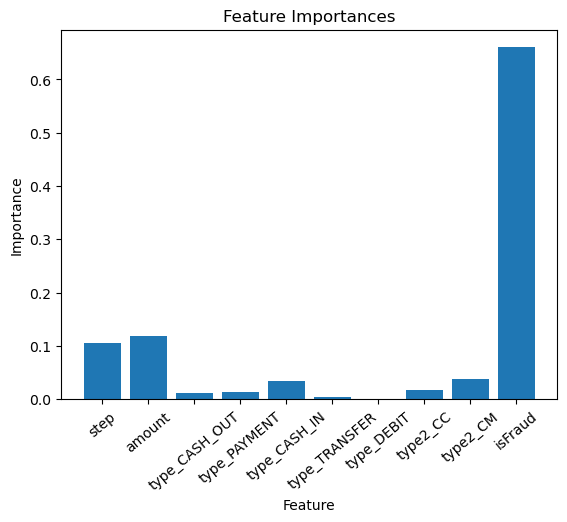

In [ ]:
# Cross Validation Model: feature importance 

bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1] # type: ignore

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

mpt.bar(x_values,importances, orientation='vertical')
mpt.xticks(x_values, columns, rotation = 40)
mpt.ylabel('Importance')
mpt.xlabel('Feature')
mpt.title('Feature Importances')


In [ ]:
bestModel_ =  cvModel.extractParamMap()

In [ ]:
bestModel_

{Param(parent='CrossValidatorModel_2748ca735c2e', name='seed', doc='random seed.'): 8945853511248409359,
 Param(parent='CrossValidatorModel_2748ca735c2e', name='numFolds', doc='number of folds for cross validation'): 3,
 Param(parent='CrossValidatorModel_2748ca735c2e', name='foldCol', doc="Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with range [0, numFolds) and Spark will throw exception on out-of-range fold numbers."): '',
 Param(parent='CrossValidatorModel_2748ca735c2e', name='estimator', doc='estimator to be cross-validated'): Pipeline_0701df93e45d,
 Param(parent='CrossValidatorModel_2748ca735c2e', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='RandomForestRegressor_83c753edd4e5', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
   Param(parent='RandomForestRegressor_83c753edd4e5', name='maxDepth', doc='Maxim

In [ ]:
# Cross Validation Model: best hyperparameters

print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))


NameError: name 'bestModel' is not defined

In [ ]:
cvModel.avgMetrics

[0.04154387943814526,
 0.04154387943814526,
 0.04154387943814526,
 0.04154387943814526,
 0.04154387943814526,
 0.04154387943814526,
 0.04154387943814526,
 0.04154387943814526,
 0.04154387943814526]

In [ ]:
zip(cvModel.avgMetrics, paramGrid)

#### We can see that the best hyperparameters in this case is:
+ numTrees : 20
+ maxDepth : 5

#### Now, we´ll use these one to build our Random Forest model.

In [ ]:
# train the model "random forest" (rf)

rf = RandomForestRegressor(labelCol='isFraud',featuresCol='my_features', maxDepth=8, numTrees=20)


NameError: name 'RandomForestRegressor' is not defined

In [ ]:
model_RF = rf.fit(train)

24/05/23 00:54:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:54:33 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:54:33 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:54:33 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:54:33 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

### Predictions

In [ ]:
# make predictions of the random forest model using the test dataset

predictions = model_RF.transform(test)

In [ ]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [ ]:
predictions.show(50)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|          prediction|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+
|   1|  6.42|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|                 0.0|
|   1|  6.93|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|                 0.0|
|   1|  8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|                 0.0|
|   1| 25.12|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],

#### We can see that there are three more columns: rawPrediction, probability and prediction. We can clearly compare the actual values and predicted values with the output below:

In [ ]:
predictions.show(50)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|             feature|            features|          prediction|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+
|   1|  6.42|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|                 0.0|
|   1|  8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|                 0.0|
|   1| 13.54|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|              

#### At a glance we can see that the predicted values are the same of the actual values, at least for the first fifty registers.

### AUC - ROC Curve (Random Forest)

In [ ]:
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")
lr_eval2 = MulticlassClassificationEvaluator(probabilityCol="prediction", labelCol="isFraud")

lr_AUC = lr_eval.evaluate(predictions) # AUC performance
lr_ACC = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"accuracy"}) # Accuracy performance

# ROC graphic

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
preds_and_labels = sc.parallelize(preds_and_labels_list)

metrics = BinaryClassificationMetrics(preds_and_labels)

# Area under ROC

print("Logistic Regression Area Under ROC:")

metrics.areaUnderROC

# Visualization

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_list]
y_score = [i[0] for i in preds_and_labels_list]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

24/05/23 01:04:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 01:04:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 01:04:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 01:04:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 01:04:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

IllegalArgumentException: DoubleType column cannot be cast to Vector

### Evaluation

#### We need to evaluate our random forest machine learning algorithm.

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction")
accuracy_ = evaluator.evaluate(predictions)

24/05/23 00:56:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:56:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:56:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:56:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:56:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [ ]:
type(accuracy_)

In [103]:
print(f"The accuracy is {accuracy_}")

NameError: name 'accuracy_' is not defined

In [ ]:
Test_Error = (1 - accuracy_)
print(f"The Test Error is {Test_Error}")

The Test Error is 0.5960906736266807


#### Let´s check out the Consufion Matrix.

In [ ]:
preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

In [ ]:
preds_and_labels.show(20)

+----------+-------+
|prediction|isFraud|
+----------+-------+
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
+----------+-------+
only showing top 20 rows



In [ ]:
# AUC - ROC

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction",)

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

# let´s store the results of this model: Random Forest

accuracy.append(accuracy_rf)

precision.append(precision_rf)

recall.append(recall_rf)

auc_roc.append(auc_rf)

# let´s store the name of the model: Random Forest 
name_model_ = "Random Forest"

name_model.append(name_model_)



print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)

print(f"Precsion: ", precision_rf)

print(f"Recall: ", recall_rf)

24/05/23 00:57:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:57:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:57:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:57:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:57:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  1.0
Accuracy:  0.3136234694614361
Precsion:  1.0
Recall:  0.3136234694614361


In [ ]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

/opt/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/23 00:59:23 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [ ]:
print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

The Confusion Matrix is:


24/05/23 00:59:24 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 00:59:24 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


array([[1059512.,       0.],
       [      0.,    4614.]])

#### Let´s use cross validation.

In [ ]:
##grid = ParamGridBuilder().addGrid(lr.)

##cv = CrossValidator(estimator=rf, evaluator=evaluator, estimatorParamMaps=)

##cvModel = cv.fit(df_bank_par)

#### According to the confusion matrix, all the actual values will be correctly predicted. It may mean an Overfitting.

### 4.2.2 Logistic Regression

#### Training

##### A. Summary of the parameters

In [ ]:
# model Logistic Regression (lr)

lr = LogisticRegression(featuresCol="my_features", labelCol="isFraud")

In [ ]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: my_features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: isFraud)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization

In [ ]:
# model Logistic Regression (lr): train

model_LR = lr.fit(train)

24/05/23 16:43:24 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:43:24 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:43:24 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:43:24 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:43:24 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [ ]:
# coefficients and intercept

print('The coefficients are:', model_LR.coefficients)
print('The independent term is:', model_LR.intercept)

The coefficients are: [0.0017840862461090978,-4.904200691325669e-09,-1.794951436855724,-1.3438215028369287,-2.976242141230391,-1.1510835511863873,-2.942112930866071,1.3438215028365235,-1.3438215028369287,36.88531824595333]
The independent term is: -18.670206043122782


In [ ]:
# model summary

summary_lr = model_LR.summary

print('The area under ROC:',summary_lr.areaUnderROC)
print('The ROC is:',summary_lr.roc.show())
print('pr is',summary_lr.pr.show())

24/05/23 16:53:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:53:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:53:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:53:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:53:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The area under ROC: 0.999999834776539
+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.006700844286839...|
|0.0| 0.01154040679797463|
|0.0|  0.0159563890501342|
|0.0|0.020459156402843792|
|0.0| 0.02468288954153328|
|0.0| 0.02910749283017133|
|0.0| 0.03329789129447736|
|0.0|0.037323915329927064|
|0.0|0.041504255918341545|
|0.0| 0.04545843798313725|
|0.0| 0.04916232262217445|
|0.0|0.052762180087704676|
|0.0| 0.05620657152873966|
|0.0| 0.05973544912726374|
|0.0| 0.06312466593483645|
|0.0| 0.06659606995683734|
|0.0| 0.06998499939652744|
|0.0| 0.07327335007730196|
|0.0| 0.07663383009661308|
+---+--------------------+
only showing top 20 rows

The ROC is: None
+--------------------+---------+
|              recall|precision|
+--------------------+---------+
|                 0.0|      1.0|
|0.006700844286839...|      1.0|
| 0.01154040679797463|      1.0|
|  0.0159563890501342|      1.0|
|0.020459156402843792|      1.0|
| 0.024

In [ ]:
summary_lr.objectiveHistory

[0.6857318254055379,
 0.2690071886860956,
 0.14569401531672682,
 0.0633077848905353,
 0.030850318141735108,
 0.014861588066495502,
 0.007239337949729511,
 0.003568679224882079,
 0.0017445779069082733,
 0.0008377751491601997,
 0.0003956771712826265,
 0.00020442638481504822,
 0.00010052991846869381,
 4.878542277309884e-05,
 2.350608874400407e-05,
 1.1786821109645318e-05,
 5.7719100272044e-06,
 2.8424634171807145e-06,
 1.4042934235611005e-06,
 6.982315769676967e-07,
 3.466621216250634e-07,
 1.5532829279736542e-07,
 7.94559581226837e-08,
 3.946691898244228e-08,
 1.977006227513949e-08,
 9.859897226488465e-09,
 4.915916074409834e-09]

##### B. Evaluators of the parameters

In [ ]:
predictions = model_LR.transform(test)

In [ ]:
predictions.show(5)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+----------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|       rawPrediction|         probability|prediction|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+----------+
|   1|  6.93|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|[21.3560649965366...|[0.99999999946889...|       0.0|
|   1| 15.06|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|[21.3560650364077...|[0.99999999946889...|       0.0|
|   1| 27.55|           0|            0|         0|           1|            0|       0|       1|      0|(

In [ ]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [ ]:
predictions = model_LR.transform(test).select("prediction", "isFraud").rdd.map(lambda x: (float(x[0]),float(x[1])))

In [ ]:
type(predictions)

pyspark.rdd.PipelinedRDD

In [ ]:
# metrics

metrics = BinaryClassificationMetrics(predictions)

/opt/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/23 16:57:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [ ]:
type(metrics)

pyspark.mllib.evaluation.BinaryClassificationMetrics

In [ ]:
metrics

In [ ]:
print('The area under ROC:',metrics.areaUnderROC)
print('The area under PR is:',metrics.areaUnderPR)

24/05/23 16:57:36 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:57:36 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:57:36 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:57:36 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 16:57:36 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The area under ROC: 1.0
The area under PR is: 1.0


##### C. Tunnig of the hyperparameters

In [ ]:
# pipeline

stages = [assembler,lr]
pipeline = Pipeline().setStages(stages)

params = ParamGridBuilder().addGrid(lr.elasticNetParam,[0.0,0.5,1.0])\
        .addGrid(lr.regParam, [0.1,2.0]) \
        .build()

In [ ]:
# evaluators: TrainValidationSplit ########################

evaluator = BinaryClassificationEvaluator()\
            .setMetricName("areaUnderROC")\
            .setRawPredictionCol("prediction") \
            .setLabelCol("isFraud")


In [ ]:
# CrossValidator

crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=params, \
                          evaluator=evaluator,numFolds=3
                         )

In [ ]:
# Cross Validation Model: train

cvModel = crossval.fit(train)

24/05/23 22:26:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 22:26:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/23 22:26:12 WARN MemoryStore: Not enough space to cache rdd_241_9 in memory! (computed 24.4 MiB so far)
24/05/23 22:26:12 WARN MemoryStore: Not enough space to cache rdd_241_5 in memory! (computed 24.3 MiB so far)
24/05/23 22:26:12 WARN MemoryStore: Not enough space to cache rdd_241_6 in memory! (computed 24.3 MiB so far)
24/05/23 22:26:12 WARN MemoryStore: Not enough space to cache rdd_241_8 in memory! (computed 24.4 MiB so far)
24/05/23 22:26:12 WARN MemoryStore: Not enough space to cache rdd_241_7 in memory! (computed 24.4 MiB so far)
24/05/23 22:26:12 WARN

ConnectionRefusedError: [Errno 61] Connection refused

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [ ]:
rfPred = cvModel.transform(df_bank_par)

rfResult = rfPred.toPandas()

mpt.plot(rfResult.isFraud, rfResult.prediction,'bo')
mpt.xlabel('isFraud')
mpt.ylabel('Prediction')
mpt.suptitle("Model Performance RMSE")
mpt.show()

# Cross Validation Model: feature importance 

bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1] # type: ignore

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

mpt.bar(x_values,importances, orientation='vertical')
mpt.xticks(x_values, columns, rotation = 40)
mpt.ylabel('Importance')
mpt.xlabel('Feature')
mpt.title('Feature Importances')

# Cross Validation Model: best hyperparameters

print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))


In [ ]:
pipeline = Pipeline(stages = [lr])

In [ ]:
paramGrid = ParamGridBuilder()\
            .addGrid(hashingTF.numFeatures,[10,100,1000])\
            .addGrid(lr.regParam,[0.1,0.01])\
            .build()

In [ ]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid,evaluator=BinaryClassificationEvaluator(), numFolds=2 )

In [ ]:
cvModel = crossval.fit(train)

24/05/20 00:10:31 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/20 00:10:31 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/20 00:10:44 WARN MemoryStore: Not enough space to cache rdd_2013_3 in memory! (computed 43.8 MiB so far)
24/05/20 00:10:44 WARN MemoryStore: Not enough space to cache rdd_2013_9 in memory! (computed 45.8 MiB so far)
24/05/20 00:10:45 WARN BlockManager: Persisting block rdd_2013_3 to disk instead.
24/05/20 00:10:45 WARN BlockManager: Persisting block rdd_2013_9 to disk instead.
24/05/20 00:10:45 WARN MemoryStore: Not enough space to cache rdd_2013_4 in memory! (computed 43.8 MiB so far)
24/05/20 00:10:45 WARN BlockManager: Persisting block rdd_2013_4 to disk in

ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
type(model_LR)

pyspark.ml.classification.LogisticRegressionModel

#### To better understand the model, we can examine its coefficients and intercept. The values represent the weights assigned to each feature and the bias term, respectively.

In [ ]:
coefficients = model_LR.coefficients

intercept = model_LR.intercept

print("Coefficients: ", coefficients)

print("Intercept: ", intercept)


#### Predictions

In [ ]:
# make predictions of the logistic regression model using the test dataset

predictions = model_LR.transform(test)

predictions.select('isfraud','prediction','probability').show(10)

+-------+----------+--------------------+
|isfraud|prediction|         probability|
+-------+----------+--------------------+
|      0|       0.0|[0.99995463738199...|
|      0|       0.0|[0.99995463721974...|
|      0|       0.0|[0.99995463708139...|
|      0|       0.0|[0.99995463697014...|
|      0|       0.0|[0.99995463691691...|
|      0|       0.0|[0.9999546368187,...|
|      0|       0.0|[0.99995463681835...|
|      0|       0.0|[0.99995463669316...|
|      0|       0.0|[0.99995463663495...|
|      0|       0.0|[0.99995463655208...|
+-------+----------+--------------------+
only showing top 10 rows



#### AUC - ROC Curve (Logistic Regression)

In [ ]:
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="isFraud")
lr_eval2 = MulticlassClassificationEvaluator(probabilityCol="probability", labelCol="isFraud")

lr_AUC = lr_eval.evaluate(predictions) # AUC performance
lr_ACC = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"accuracy"}) # Accuracy performance

24/05/19 17:03:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/19 17:03:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/19 17:03:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/19 17:03:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/19 17:03:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [ ]:
# ROC graphic

preds_and_labels = predictions.select("probability", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
preds_and_labels = sc.parallelize(preds_and_labels_list)

metrics = BinaryClassificationMetrics(preds_and_labels)

24/05/19 17:06:55 ERROR Inbox: An error happened while processing message in the inbox for HeartbeatReceiver
java.lang.OutOfMemoryError: GC overhead limit exceeded
24/05/19 17:06:55 ERROR Utils: Uncaught exception in thread executor-heartbeater
java.lang.OutOfMemoryError: GC overhead limit exceeded
Exception in thread "dispatcher-HeartbeatReceiver" java.lang.OutOfMemoryError: GC overhead limit exceeded


Py4JJavaError: An error occurred while calling o738.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded


24/05/19 17:07:02 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 163888 ms exceeds timeout 120000 ms
24/05/19 17:07:02 WARN SparkContext: Killing executors is not supported by current scheduler.


In [ ]:
# Area under ROC

print("Logistic Regression Area Under ROC:")

metrics.areaUnderROC

Logistic Regression Area Under ROC:


24/05/19 02:31:06 WARN TaskSetManager: Stage 322 contains a task of very large size (6636 KiB). The maximum recommended task size is 1000 KiB.
24/05/19 02:31:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/19 02:31:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/19 02:31:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/19 02:31:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
2

0.9999998806070997

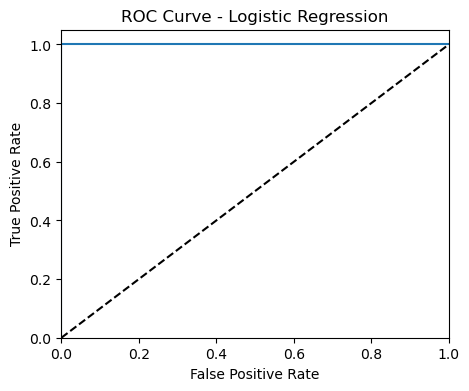

In [ ]:
# Visualization

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_list]
y_score = [i[0] for i in preds_and_labels_list]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

#### According to this graphic we have overfitting in our model. Therefore, we need to adjunts some hyperparameters in the model, which is in previos steps.

#### Evaluation

In [ ]:
# AUC - ROC

evaluator = BinaryClassificationEvaluator(rawPredictionCol="Prediction", labelCol="isFraud")

auc_lr = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_lr = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_lr = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_lr = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

# let´s store the results of this model: Random Forest

accuracy.append(accuracy_lr)

precision.append(precision_lr)

recall.append(recall_lr)

auc_roc.append(auc_lr)

# let´s store the name of the model: Logistic Regression 
name_model_ = "Logistic Regression"

name_model.append(name_model_)


print(f"AUC-ROC: ", auc_lr)

print(f"Accuracy: ", accuracy_lr)

print(f"Precsion: ", precision_lr)

print(f"Recall: ", recall_lr)

#### Let´s check out the Confusion Matrix.

In [ ]:
preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

/opt/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/17 23:20:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


The Confusion Matrix is:


24/05/17 23:20:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 23:20:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


array([[1903276.,       0.],
       [      0., 1491116.]])

In [ ]:
df_bank_par.printSchema()

ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
# it does not work yet.....

evaluator = BinaryClassificationEvaluator()

grid = ParamGridBuilder().addGrid(lr.maxIter,[0,1]).build()

cv = CrossValidator(estimator=lr,  estimatorParamMaps=grid,evaluator=evaluator, parallelism=2)

cvModel = cv.fit(train)

#cvModel.avgMetrics[0]

24/05/17 23:21:34 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 23:21:34 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 23:21:40 WARN MemoryStore: Not enough space to cache rdd_791_8 in memory! (computed 24.4 MiB so far)
24/05/17 23:21:40 WARN MemoryStore: Not enough space to cache rdd_791_0 in memory! (computed 23.6 MiB so far)
24/05/17 23:21:40 WARN BlockManager: Persisting block rdd_791_8 to disk instead.
24/05/17 23:21:40 WARN BlockManager: Persisting block rdd_791_0 to disk instead.
24/05/17 23:21:40 WARN MemoryStore: Not enough space to cache rdd_791_5 in memory! (computed 24.3 MiB so far)
24/05/17 23:21:40 WARN MemoryStore: Not enough space to cache rdd_791_7 in memor

Py4JJavaError: An error occurred while calling o4336.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 282.0 failed 1 times, most recent failure: Lost task 1.0 in stage 282.0 (TID 1588) (192.168.1.3 executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:57)
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:335)
	at org.apache.spark.sql.execution.columnar.ColumnBuilder$.ensureFreeSpace(ColumnBuilder.scala:167)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.appendFrom(ColumnBuilder.scala:73)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$appendFrom(ColumnBuilder.scala:93)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.appendFrom(NullableColumnBuilder.scala:61)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.appendFrom$(NullableColumnBuilder.scala:54)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.appendFrom(ColumnBuilder.scala:93)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:105)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:80)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:290)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:287)
	at org.apache.spark.storage.memory.PartiallyUnrolledIterator.next(MemoryStore.scala:785)
	at org.apache.spark.serializer.SerializationStream.writeAll(Serializer.scala:140)
	at org.apache.spark.serializer.SerializerManager.dataSerializeStream(SerializerManager.scala:177)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3(BlockManager.scala:1606)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3$adapted(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$5940/1082377634.apply(Unknown Source)
	at org.apache.spark.storage.DiskStore.put(DiskStore.scala:88)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$2258/29328023.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2622/165740715.apply(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:57)
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:335)
	at org.apache.spark.sql.execution.columnar.ColumnBuilder$.ensureFreeSpace(ColumnBuilder.scala:167)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.appendFrom(ColumnBuilder.scala:73)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$appendFrom(ColumnBuilder.scala:93)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.appendFrom(NullableColumnBuilder.scala:61)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.appendFrom$(NullableColumnBuilder.scala:54)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.appendFrom(ColumnBuilder.scala:93)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:105)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:80)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:290)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:287)
	at org.apache.spark.storage.memory.PartiallyUnrolledIterator.next(MemoryStore.scala:785)
	at org.apache.spark.serializer.SerializationStream.writeAll(Serializer.scala:140)
	at org.apache.spark.serializer.SerializerManager.dataSerializeStream(SerializerManager.scala:177)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3(BlockManager.scala:1606)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3$adapted(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$5940/1082377634.apply(Unknown Source)
	at org.apache.spark.storage.DiskStore.put(DiskStore.scala:88)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$2258/29328023.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2622/165740715.apply(Unknown Source)


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50613)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/socketserve

### 4.2.3 Decision Tree

#### Training

In [105]:
# train the model Decision Tree (dt)

dt = DecisionTreeClassifier(featuresCol='features', labelCol='isFraud')
dt.explainParams
#model_dt = dt.fit(train)

ConnectionRefusedError: [Errno 61] Connection refused

#### Predictions

In [ ]:
# make predictions of the decision tree model using the test dataset

predictions = model_dt.transform(test)

predictions.show(50)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+---------------+-----------+----------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|            features|  rawPrediction|probability|prediction|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+---------------+-----------+----------+
| 1.0|  8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|[4441370.0,0.0]|  [1.0,0.0]|       0.0|
| 1.0| 23.31|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|[4441370.0,0.0]|  [1.0,0.0]|       0.0|
| 1.0| 38.66|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|[4441370.0,0.0]|  [1.0,0.0]|       0.0|
| 1.0| 96.

#### AUC - ROC Curve (Decision Tree)

In [ ]:
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="isFraud")
lr_eval2 = MulticlassClassificationEvaluator(probabilityCol="probability", labelCol="isFraud")

lr_AUC = lr_eval.evaluate(predictions) # AUC performance
lr_ACC = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"accuracy"}) # Accuracy performance

# ROC graphic

preds_and_labels = predictions.select("probability", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
preds_and_labels = sc.parallelize(preds_and_labels_list)

metrics = BinaryClassificationMetrics(preds_and_labels)

# Area under ROC

print("Logistic Regression Area Under ROC:")

metrics.areaUnderROC

# Visualization

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_list]
y_score = [i[0] for i in preds_and_labels_list]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

#### Evaluation

In [ ]:
# AUC - ROC

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="isFraud")

auc_dt = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction",)

accuracy_dt = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

# let´s store the results of this model: Decision Tree

accuracy.append(accuracy_dt)

precision.append(precision_dt)

recall.append(recall_dt)

auc_roc.append(auc_dt)


# let´s store the name of the model: Decision Tree
name_model_ = "Decision Tree"

name_model.append(name_model_)

print(f"AUC-ROC: ", auc_dt)

print(f"Accuracy: ", accuracy_dt)

print(f"Precsion: ", precision_dt)

print(f"Recall: ", recall_dt)

24/05/17 20:15:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:15:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:15:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:15:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:15:06 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  1.0
Accuracy:  1.0
Precsion:  1.0
Recall:  1.0


#### Let´s check out the Confusion Matrix.

In [ ]:
preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

In [ ]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

24/05/17 20:15:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [ ]:
print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

The Confusion Matrix is:


24/05/17 20:16:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:16:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


array([[1905550.,       0.],
       [      0., 1527301.]])

### 4.2.4 Naive Bayes

#### Training

In [ ]:
# train the model Naive Bayes (nb)

nb = NaiveBayes(featuresCol='features', labelCol='isFraud')

model_nb = nb.fit(train)

#### Predictions

In [ ]:
# make predictions of the naive bayes model using the test dataset

predictions = model_nb.transform(test)

predictions.show(50)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+----------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|            features|       rawPrediction|         probability|prediction|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+----------+
| 1.0|  8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|[-33.476857610643...|[0.99999999999999...|       0.0|
| 1.0| 23.31|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|[-33.497407161157...|[0.99999999999999...|       0.0|
| 1.0| 38.66|           0|            0|         0|           1|            0|       0|       1|      0|(

#### AUC - ROC Curve (Naive Bayes)

In [ ]:
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="isFraud")
lr_eval2 = MulticlassClassificationEvaluator(probabilityCol="probability", labelCol="isFraud")

lr_AUC = lr_eval.evaluate(predictions) # AUC performance
lr_ACC = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"accuracy"}) # Accuracy performance

# ROC graphic

preds_and_labels = predictions.select("probability", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
preds_and_labels = sc.parallelize(preds_and_labels_list)

metrics = BinaryClassificationMetrics(preds_and_labels)

# Area under ROC

print("Logistic Regression Area Under ROC:")

metrics.areaUnderROC

# Visualization

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_list]
y_score = [i[0] for i in preds_and_labels_list]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

#### Evaluation

In [ ]:
# AUC - ROC

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="isFraud")

auc_nb = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction",)

accuracy_nb = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_nb = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_nb = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

# let´s store the results of this model: Naive Bayes

accuracy.append(accuracy_nb)

precision.append(precision_nb)

recall.append(recall_nb)

auc_roc.append(auc_nb)

# let´s store the name of the model: Naive Bayes
name_model_ = "Naive Bayes"

name_model.append(name_model_)


print(f"AUC-ROC: ", auc_nb)

print(f"Accuracy: ", accuracy_nb)

print(f"Precsion: ", precision_nb)

print(f"Recall: ", recall_nb)

24/05/17 20:17:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:17:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:17:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:17:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:17:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  0.26641219845130204
Accuracy:  0.6753345834118638
Precsion:  0.6772445219431403
Recall:  0.6753345834118638


#### Let´s check out the Confusion Matrix.

In [ ]:
preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

24/05/17 20:17:58 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


The Confusion Matrix is:


24/05/17 20:17:59 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/17 20:17:59 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


array([[1557022.,  348528.],
       [ 766000.,  761301.]])

## 4.3 Evaluation and Selection of the model

We´ll evaluate the models using the metrics used in the previous step and we´ll select the model with the best performance. As first step, let´s create a dictionary with the results of every model.

In [ ]:
results = {
    'Name_Model': name_model,
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'AUC_ROC':auc_roc
}

In [ ]:
results

{'Name_Model': ['Random Forest'],
 'Accuracy': [0.3136234694614361],
 'Precision': [1.0],
 'Recall': [0.3136234694614361],
 'AUC_ROC': [1.0]}

In [ ]:
type(results['Accuracy'][2])

IndexError: list index out of range

#### Now, let´s create a pandas dataframe with the results dictionary.

In [ ]:
results_df = pd.DataFrame(results)
results_df.set_index('Name_Model', inplace=True)
#results_df.set_index("Name_Model", inplace=True)

In [ ]:
results_df.head(5)

,Accuracy,Precision,Recall,AUC_ROC
Name_Model,,,,
Random Forest,0.313623,1.0,0.313623,1.0


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, Random Forest to Random Forest
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Accuracy   1 non-null      float64
 1   Precision  1 non-null      float64
 2   Recall     1 non-null      float64
 3   AUC_ROC    1 non-null      float64
dtypes: float64(4)
memory usage: 40.0+ bytes


In [ ]:
results_df

In [ ]:
type(results_df)

#### Let´s visualize these results.

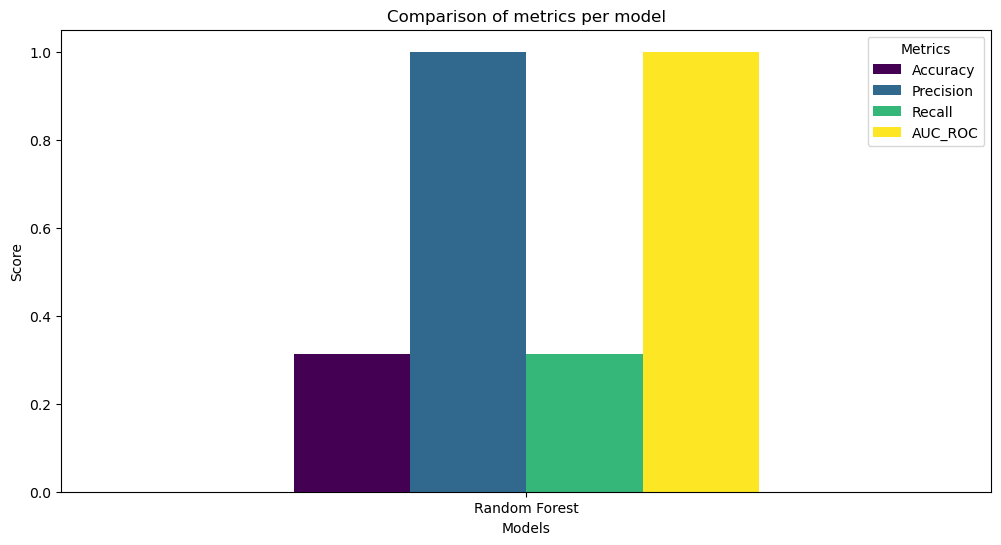

""


In [ ]:
# "results_df" dataframe

colors = ['#0077b6','#CDDBF3','#9370DB','#DDA0DD']
results_df.plot(kind='bar', figsize=(12,6), colormap='viridis', rot=0)
mpt.title('Comparison of metrics per model')
mpt.xlabel('Models')
mpt.ylabel('Score')
mpt.legend(title = 'Metrics')
mpt.tight_layout
mpt.show()

pd.DataFrame()

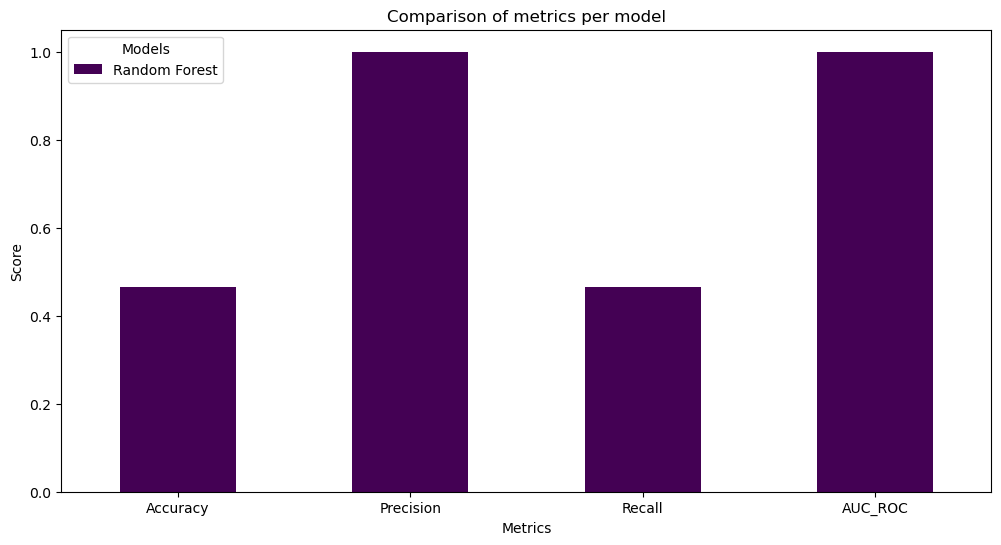

In [ ]:
# transpose of the "results_df" dataframe

results_df = results_df.T
colors = ['#0077b6','#CDDBF3','#9370DB','#DDA0DD']
results_df.plot(kind='bar', figsize=(12,6), colormap='viridis', rot=0)
mpt.title('Comparison of metrics per model')
mpt.xlabel('Metrics')
mpt.ylabel('Score')
mpt.legend(title = 'Models')
mpt.tight_layout
mpt.show()


## 5. Storage

### 5.1 Model

In [ ]:
# model: Random Forest

model_RF.save("randomF_model")

# model: Logistic Regression

model_LR.save("logit_model")

# model: Decision Tree

model_dt.save("decisionT_model")

# model: Naive Bayes

model_nb.save("naiveB_model")


### 5.2 Load

In [ ]:
# model: Random Forest

loaded_model_RF = RandomForestClassifier.load("randomF_model")

# model: Logistic Regression

loaded_model_LR = LogisticRegression.load("logit_model")

# model: Decision Tree

loaded_model_LR = DecisionTreeClassifier.load("decisionT_model")

# model: Naive Bayes

loaded_model_LR = NaiveBayes.load("naiveB_model")